## Structural Preservation Analysis
C. Heiser, October 2020

In [1]:
from fcc_utils import *  # contains code necessary for distance preservation analysis, including scanpy and related functions

---
### Preprocessing & Dimension Reduction with `scanpy`

[`AnnData`](https://anndata.readthedocs.io/en/stable/anndata.AnnData.html) objects can be read straight from a compressed `.h5ad` file, containing metadata and reduced dimensions.

Here, we will read in a manually-filtered `.h5ad` file for our human colonic mucosa data.

In [3]:
a = sc.read("Filtered_3907_Data.h5ad") ; a

AnnData object with n_obs × n_vars = 2596 × 29426

These objects have a bunch of useful attributes, and it's easy to calculate some QC metrics and preprocess the raw counts:

In [4]:
# get useful metrics of counts data
a.var["mito"] = a.var_names.str.contains("MT:")
sc.pp.calculate_qc_metrics(a, qc_vars=["mito"], inplace=True)

# preprocess AnnData for downstream dimensionality reduction
a.layers["raw_counts"] = a.X.copy() # save raw counts in layer
arcsinh(a, layer="raw_counts", norm="l1", scale=1000) # arcsinh-transform normalized counts and add to .layers['arcsinh_norm']
a.X = a.layers["arcsinh_norm"].copy() # set normalized counts as .X slot in scanpy object

# see resulting AnnData contents
a

AnnData object with n_obs × n_vars = 2596 × 29426
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'raw_counts', 'arcsinh_norm'

We can use `sc.pp.highly_variable_genes` to filter our dataset for HVGs:

In [5]:
sc.pp.highly_variable_genes(a, n_top_genes=2000)

Now we can perform an initial dimension reduction with __principal component analysis__.

/home/cody/.virtualenvs/star/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


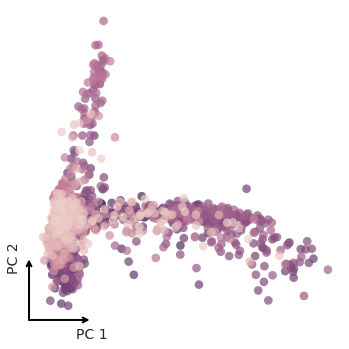

In [6]:
sc.tl.pca(a, n_comps=100) # perform 100-component PCA on our feature-selected dataset
DR_plot(dim_name='PC', figsize=(5,5)).plot(a.obsm['X_pca'], color=a.obs['log1p_total_counts'])

Using the 100 principal components above, we can perform __Louvain__ clustering to determine subpopulations.

In [7]:
n_neighbs = int(np.sqrt(a.n_obs))  # determine optimal number of neighbors by sqrt(n_obs)
print("Number of nearest neighbors: {}".format(n_neighbs))

Number of nearest neighbors: 50


In [8]:
%%time
sc.pp.neighbors(a, n_neighbors=n_neighbs, n_pcs=100, random_state=18)
sc.tl.leiden(a, random_state=18)

CPU times: user 3.7 s, sys: 1.89 s, total: 5.58 s
Wall time: 2.5 s


Now we can perform our favorite low-dimensional embedding on the principal components of our dataset:

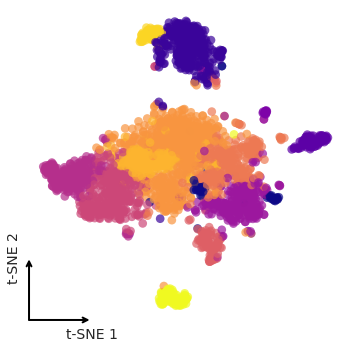

In [9]:
sc.tl.tsne(a, use_rep="X_pca")
DR_plot(dim_name="t-SNE", figsize=(5,5)).plot_IDs(adata=a, use_rep="X_tsne", obs_col="leiden")

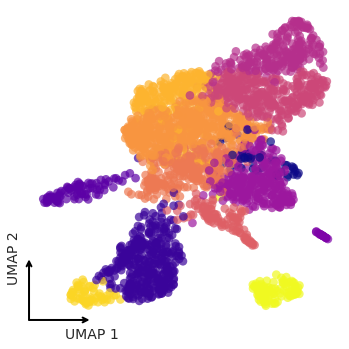

In [10]:
sc.tl.umap(a)
DR_plot(dim_name="UMAP", figsize=(5,5)).plot_IDs(adata=a, use_rep="X_umap", obs_col="leiden")

---
### Global Structure Preservation

We can easily apply the `scipy.spatial.distance.cdist()` function to different parts of our `AnnData` objects to get symmetric distance matrices between all cells in the dataset across multiple low-dimensional latent spaces.

In [11]:
%%time
# save distance matrix in AnnData object for easy access
a.uns["X_pca_distances"] = cdist(a.obsm["X_pca"], a.obsm["X_pca"])
a.uns["X_tsne_distances"] = cdist(a.obsm["X_tsne"], a.obsm["X_tsne"])

# calculate simple binary knn graph from the distance matrix above
knn_graph(a.uns["X_pca_distances"], k=n_neighbs, adata=a, save_rep="pca_knn")
knn_graph(a.uns["X_tsne_distances"], k=n_neighbs, adata=a, save_rep="tsne_knn")

CPU times: user 42.8 s, sys: 0 ns, total: 42.8 s
Wall time: 2.93 s


Using our `distance_stats` function, we can calculate structural preservation metrics between latent t-SNE space and its corresponding native PCA space.  

In [12]:
%time pca_dist, tsne_dist, corr_stats, EMD = distance_stats(pre=a.uns["X_pca_distances"], post=a.uns["X_tsne_distances"])
knn = knn_preservation(pre=a.uns["pca_knn"]["graph"], post=a.uns["tsne_knn"]["graph"])
print("\nR: {}\nEMD: {}\nKnn Pres. (%): {}".format(round(corr_stats[0],4), round(EMD,4), round(knn, 4)))

Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
CPU times: user 1.67 s, sys: 1.39 s, total: 3.06 s
Wall time: 1.4 s

R: 0.5961
EMD: 0.1128
Knn Pres. (%): 97.3568


/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


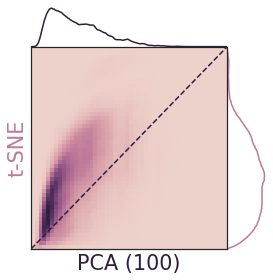

In [13]:
SP_plot(pre_norm=pca_dist, post_norm=tsne_dist, labels=["PCA (100)","t-SNE"]).joint_plot_distance_correlation()

You can also look at the normalized cumulative distance distributions in each projection and calculate the __Wasserstein metric__ or __Earth Mover's Distance__ between the two.

EMD: 0.1128


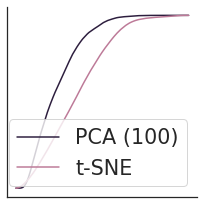

In [14]:
SP_plot(pre_norm=pca_dist, post_norm=tsne_dist, labels=["PCA (100)","t-SNE"], figsize=(3,3)).plot_cumulative_distributions()
print("EMD: {}".format(round(EMD,4)))

__AND__ if we want to do this all very quickly, there's a wrapper function for `AnnData` objects so you don't have to manually calculate and save distance matrices as above.  
Let's do this for our UMAP calculations.

Calculating unique distances for latent space, X_umap
Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions
50-nearest neighbor calculation for native space, X_pca
50-nearest neighbor calculation for latent space, X_umap
Determining nearest neighbor preservation
Done!
CPU times: user 45.5 s, sys: 1.36 s, total: 46.8 s
Wall time: 4.19 s

R: 0.5811
EMD: 0.0798
Knn Pres.: 97.3834


/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


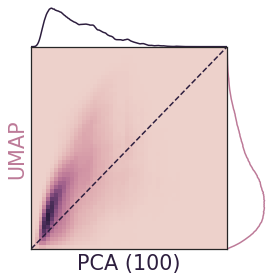

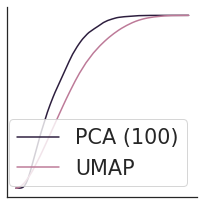

In [15]:
%time corr, EMD, knn = structure_preservation_sc(adata=a, latent="X_umap", native="X_pca", k=n_neighbs)
print("\nR: {}\nEMD: {}\nKnn Pres.: {}".format(round(corr[0],4), round(EMD,4), round(knn, 4)))
SP_plot(pre_norm=a.uns["X_pca_norm_distances"], post_norm=a.uns["X_umap_norm_distances"], labels=["PCA (100)","UMAP"]).joint_plot_distance_correlation()
SP_plot(pre_norm=a.uns["X_pca_norm_distances"], post_norm=a.uns["X_umap_norm_distances"], labels=["PCA (100)","UMAP"], figsize=(3,3)).plot_cumulative_distributions()

---
### Local Structure Preservation
We can extend this framework to defined substructures in our data.  
Here, let's look at cluster __"0"__ as output from the __Leiden__ algorithm above.  
First, plot this cluster in all three spaces (PCA, t-SNE, UMAP).

/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

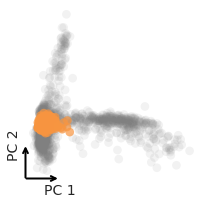

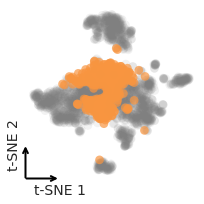

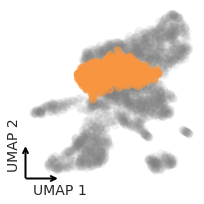

In [16]:
DR_plot(dim_name="PC", figsize=(3,3)).plot_IDs(adata=a, use_rep="X_pca", obs_col="leiden", IDs=["0"])
DR_plot(dim_name="t-SNE", figsize=(3,3)).plot_IDs(adata=a, use_rep="X_tsne", obs_col="leiden", IDs=["0"])
DR_plot(dim_name="UMAP", figsize=(3,3)).plot_IDs(adata=a, use_rep="X_umap", obs_col="leiden", IDs=["0"])

We can subset our distance matrices by `adata.obs['leiden']` and calculate structural preservation metrics as before

In [17]:
subset_uns_by_ID(
    a, 
    uns_keys=["X_pca_distances","X_tsne_distances","X_umap_distances"], 
    obs_col="leiden", 
    IDs=["0"]
)

Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions

R: 0.191
EMD: 0.0256


/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


CPU times: user 2.42 s, sys: 4 s, total: 6.43 s
Wall time: 1.25 s


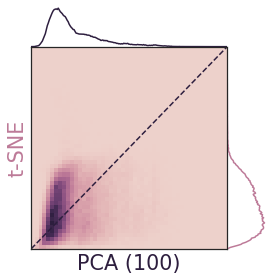

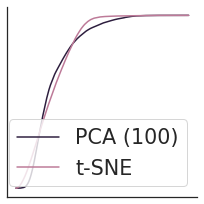

In [18]:
%%time
pca_dist_0, tsne_dist_0, corr_stats_0, EMD_0 = distance_stats(pre=a.uns["X_pca_distances_0"], post=a.uns["X_tsne_distances_0"])
print("\nR: {}\nEMD: {}".format(round(corr_stats_0[0],4), round(EMD_0,4)))
SP_plot(pre_norm=pca_dist_0, post_norm=tsne_dist_0, labels=["PCA (100)","t-SNE"], figsize=(4,4)).joint_plot_distance_correlation()
SP_plot(pre_norm=pca_dist_0, post_norm=tsne_dist_0, labels=["PCA (100)","t-SNE"], figsize=(3,3)).plot_cumulative_distributions()

Let's do the same for __UMAP__ to compare to __t-SNE__.

Flattening pre-transformation distance matrix into 1D array...
Flattening post-transformation distance matrix into 1D array...
Correlating distances
Normalizing unique distances
Calculating Earth-Mover's Distance between distributions

R: 0.0859
EMD: 0.1378


/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1649: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


CPU times: user 2.37 s, sys: 4.05 s, total: 6.42 s
Wall time: 1.24 s


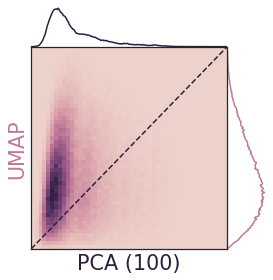

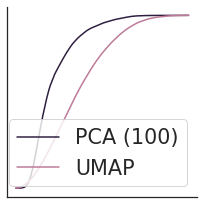

In [19]:
%%time
pca_dist_0, umap_dist_0, corr_stats_0, EMD_0 = distance_stats(pre=a.uns["X_pca_distances_0"], post=a.uns["X_umap_distances_0"])
print("\nR: {}\nEMD: {}".format(round(corr_stats_0[0],4), round(EMD_0,4)))
SP_plot(pre_norm=pca_dist_0, post_norm=umap_dist_0, labels=["PCA (100)","UMAP"], figsize=(4,4)).joint_plot_distance_correlation()
SP_plot(pre_norm=pca_dist_0, post_norm=umap_dist_0, labels=["PCA (100)","UMAP"], figsize=(3,3)).plot_cumulative_distributions()

---
### Neighborhood Preservation

We also have a nice wrapper function to compare the _pairwise distance distributions_ between cells in three clusters.  
Let's pick a few cluster IDs and plot them in each latent space.

/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

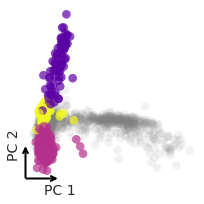

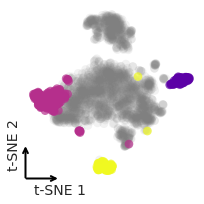

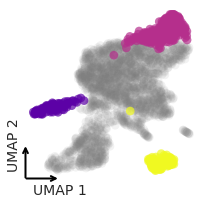

In [20]:
DR_plot(dim_name="PC", figsize=(3,3)).plot_IDs(adata=a, use_rep="X_pca", obs_col="leiden", IDs=["5","8","9"])
DR_plot(dim_name="t-SNE", figsize=(3,3)).plot_IDs(adata=a, use_rep="X_tsne", obs_col="leiden", IDs=["5","8","9"])
DR_plot(dim_name="UMAP", figsize=(3,3)).plot_IDs(adata=a, use_rep="X_umap", obs_col="leiden", IDs=["5","8","9"])

Now run `cluster_arrangement_sc` to see how the local neighborhoods defined between substructures are altered in __t-SNE__ compared to __100-component PCA__.

/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distr

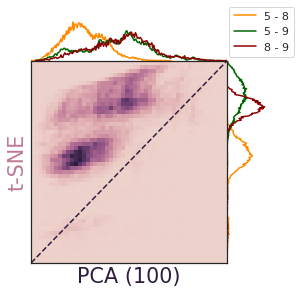

In [21]:
corr_tSNE, EMD_tSNE = cluster_arrangement_sc(
    adata=a, 
    pre=a.obsm["X_pca"], 
    post=a.obsm["X_tsne"], 
    obs_col="leiden", IDs=["5","8","9"], 
    ax_labels=["PCA (100)","t-SNE"], 
    figsize=(4,4)
)

We can do the same thing for __UMAP__.

/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.01 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/distr

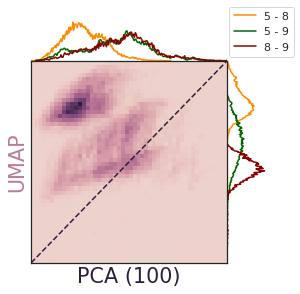

In [22]:
corr_UMAP, EMD_UMAP = cluster_arrangement_sc(
    adata=a, 
    pre=a.obsm["X_pca"], 
    post=a.obsm["X_umap"], 
    obs_col="leiden", IDs=["5","8","9"], 
    ax_labels=["PCA (100)","UMAP"], 
    figsize=(4,4)
)

The correlation and EMD values _between_ each cluster are returned by the above function:

In [23]:
corr_tSNE

[0.3615849019566696, 0.4872405197942745, 0.3012465372541705]

In [24]:
corr_UMAP

[0.49847257758095714, 0.5700244740548929, 0.5424877755567995]

---
### Topological Cluster Preservation
Finally, to get an idea of the global arrangement of substructures relative to one another, we construct a minimum-spanning tree (MST) graph between cluster centroids in native and latent spaces.  
Permuted edges from one graph to another indicate rearrangement of cluster topology following dimension reduction.

In [25]:
find_centroids(a, use_rep="X_pca", obs_col="leiden")
find_centroids(a, use_rep="X_tsne", obs_col="leiden")
find_centroids(a, use_rep="X_umap", obs_col="leiden")

The above function generates a `networkx` graph in `adata.uns['*_centroid_MST']`.  We can compare the `.edges` attribute of these graphs to determine which ones changed.  
Furthermore, we have a nice visualization function (`DR_plot().plot_centroids()`) to overlay the graph on our embeddings.

6 permuted edges from native space.


/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


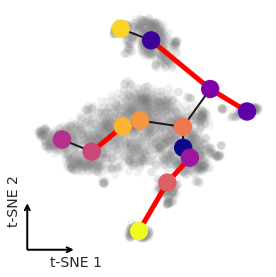

In [26]:
tsne_set = set(a.uns["X_tsne_centroid_MST"].edges).difference(set(a.uns["X_pca_centroid_MST"].edges))
print("{} permuted edges from native space.".format(len(tsne_set)))

DR_plot(dim_name="t-SNE", figsize=(4,4)).plot_centroids(adata=a, obs_col="leiden", use_rep="X_tsne", highlight_edges=tsne_set)

6 permuted edges from native space.


/home/cody/.virtualenvs/star/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


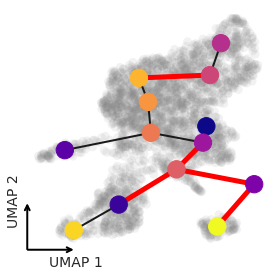

In [27]:
umap_set = set(a.uns["X_umap_centroid_MST"].edges).difference(set(a.uns["X_pca_centroid_MST"].edges))
print("{} permuted edges from native space.".format(len(umap_set)))

DR_plot(dim_name="UMAP", figsize=(4,4)).plot_centroids(adata=a, obs_col="leiden", use_rep="X_umap", highlight_edges=umap_set)